In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/python-gsw/')
import gsw

No joblib
no cmocean


In [2]:
# ==============================================================================
# Running this file loads tracers from old FESOM-REcoM2 output file (oce.mean.nc)
# and saves each tracer in an individual file
# 
#  Input:
#  - mesh_id: Name of mesh, will be added to the netcdf name
#  - meshpath: Speciefies where the target mesh is stored
#  - save_netcdf: If true, netcdf will be created
#  - delete_old_netcdf: If a netcdf file with the same name exists, a new cannot 
#    be made. If set to true, an old netcdf with the same name will be deleted
#
#  Output:
#  - netcdf file for each tracer in the old file
#  
#  During running, keep an eye on the output in the terminal, to see if it 
#  makes sense. 
#
# ==============================================================================

In [3]:
# Loading mesh for run

tracername = 'WAPE'
mesh_id    = 'meshArc4.5'
runid	= 'Arc12'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)

In [4]:
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True) 
mesh

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh



FESOM mesh:
path                  = /gfs2/work/hbkvsk12/mesh/meshArc4.5
alpha, beta, gamma    = 50, 15, -90
number of 2d nodes    = 753179
number of 2d elements = 1480268
number of 3d nodes    = 16950142

        

In [10]:
year = 2012
ncfile	= data_path+tracername+'.'+str(year)+'.monthly.nc'
f	= Dataset(ncfile,'r')
data = f.variables['APE'][:]

For depth 0 model level -0.0 will be used
Number of nans in tracer:  16307
Number of inf in tracer:  0
Mean of surface:  2.7533038300822836
Max and min:  40.39824283462342 0.0


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater_equal


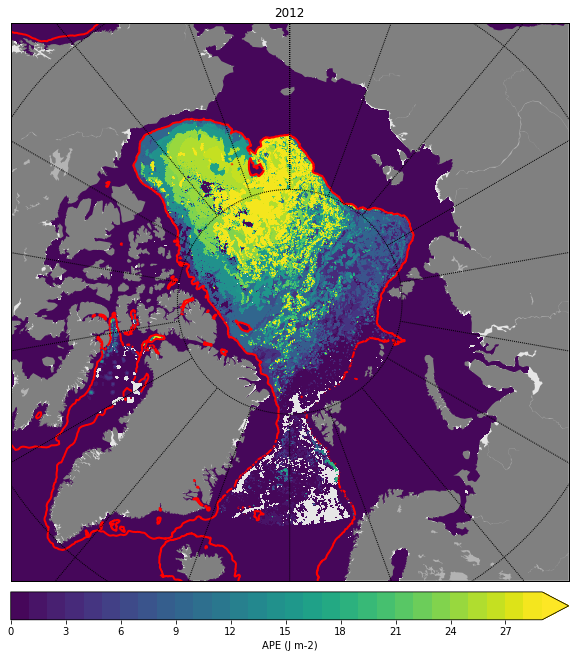

In [11]:
data2, elem_no_nan = pf.get_data(data,mesh,0)
data2=np.copy(data2)
data2 = data2 /10**5
print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.nanmean(data2)
print 'Max and min: ',np.nanmax(data2),np.nanmin(data2)

contours = np.arange(0, 30, 1)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=65,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.9')
m.fillcontinents(color='.5',lake_color='.7')

eps=(contours.max()-contours.min())/100.
data2[data2<=contours.min()]=contours.min()+eps
data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2, levels=contours, cmap=cm.viridis, extend='max')
#plt.tricontour(x, y, elem_no_nan, mesh.topo,levels=([350]),colors='red',linewidths=2)
plt.tricontour(x, y, elem_no_nan, mesh.topo,levels=([500]),colors='red',linewidths=2)

label = 'APE (J m-2)'
plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label)

#plt.savefig(saving_directory+'ChlNano.png', dpi = 200, bbox_inches='tight')
plt.show()

In [12]:
import pandas as pd
import xarray as xr

In [16]:
dates = pd.date_range('1985', freq="Y", periods= len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates

In [19]:
ANPP_sel = data.APE.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
ANPP_sel = ANPP_sel.compute()
ANPP_mean = ANPP_sel.mean(dim='time')
ANPP_mean = ANPP_mean.compute()
ANPP_min = ANPP_sel.min(dim='time')
ANPP_min = ANPP_min.compute()

In [23]:
ANPP_sel.dropna()
pf = np.polyfit(years, ANPP_sel, 1)

TypeError: dropna() takes at least 2 arguments (1 given)